In [1]:
import gym
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = 'FrozenLake-v1'
env = gym.make(name, is_slippery=False)
env.seed(42)
env.action_space.seed(42)

print('action space: ' + str(env.action_space))
print('reward range: ' + str(env.reward_range))
print('observation space: ' + str(env.observation_space))

action space: Discrete(4)
reward range: (0, 1)
observation space: Discrete(16)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

In [3]:
# actions
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

env.reset()
next_state, reward, terminated, info = env.step(DOWN)
print('next state: ' + str(next_state))
print('reward: ' + str(reward))
print('terminated: ' + str(terminated))
print('info: ' + str(info))

next state: 4
reward: 0.0
terminated: False
info: {'prob': 1.0}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
# helper function to draw the frozen lake
def plot(V, policy, col_ramp=1, dpi=175, draw_vals=False):
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32, 0.36, 0.38)})
    plt.rcParams.update({'font.size': 4 if env.env.nrow == 8 else 7})
    plt.figure(figsize=(3,3))
    plt.imshow(1-V.reshape(env.env.nrow, env.env.ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(env.env.ncol)-.5)
    ax.set_yticks(np.arange(env.env.nrow)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for s in range(env.observation_space.n):
        x= s%env.env.nrow
        y = int(s/env.env.ncol)
        a = policy[s]
        gray = np.array((0.32,0.36,0.38))
        if env.desc.tolist()[y][x] == b'G':
            plt.text(x-0.45,y-0.3, 'goal', color=(0.75,0.22,0.17), weight='bold')
            continue
        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # left
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # down
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # right
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # up
        if env.desc.tolist()[y][x] == b'F': plt.text(x-0.45,y-0.3, 'ice', color=(gray*V[s]))
        if env.desc.tolist()[y][x] == b'S': plt.text(x-0.45,y-0.3, 'start', color=(0.21,0.51,0.48), weight='bold')

        if draw_vals and V[s] > 0:
            vstr = '{0:.1e}'.format(V[s]) if env.env.nrow == 8 else '{:.6f}'.format(V[s])
            plt.text(x-0.45,y+0.45, vstr, color=(gray*V[s]))
    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42,0.46,0.48), which='both', top='off', left='off', right='off', bottom='off')
    plt.show()

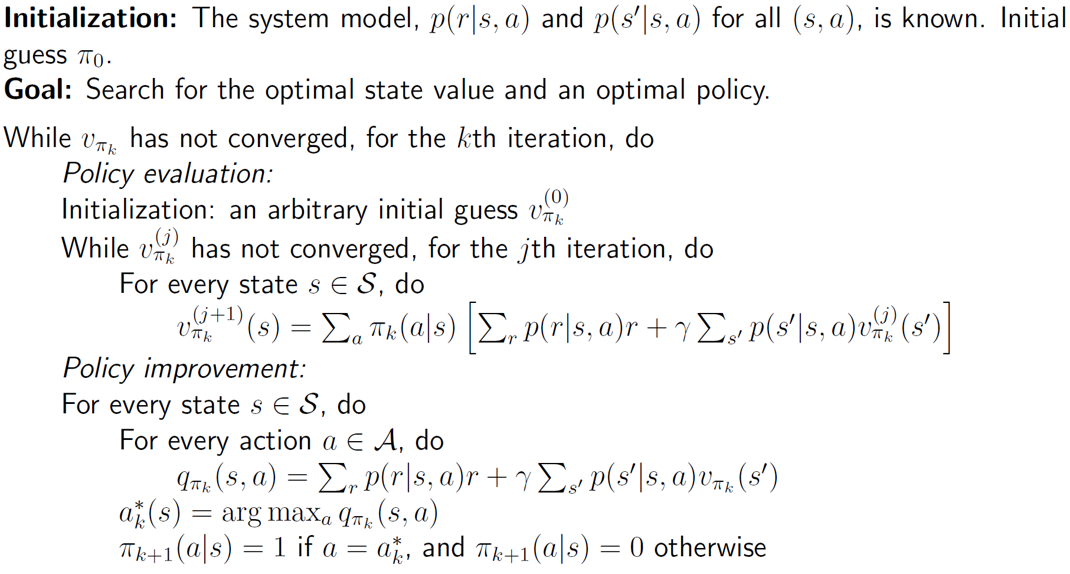

In [5]:
def policy_evaluation(env, policy, gamma=1, theta=1e-6, draw=False):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if draw: plot(V, policy, draw_vals=True)
        if delta < theta:
            break
    return V

In [6]:
# create a uniform random policy
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
V = policy_evaluation(env, policy, draw=False)

In [7]:
V

array([0.0139372 , 0.01162942, 0.02095187, 0.01047569, 0.01624741,
       0.        , 0.04075119, 0.        , 0.03480561, 0.08816967,
       0.14205297, 0.        , 0.        , 0.17582021, 0.43929104,
       0.        ])

In [8]:
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
V = policy_evaluation(env, policy, gamma=0.9, draw=False)
print(V)

[0.00447571 0.00422165 0.01006621 0.00411784 0.00672128 0.
 0.02633356 0.         0.01867586 0.0576069  0.10697187 0.
 0.         0.13038299 0.39149011 0.        ]


Get $q_\pi$ from $v_\pi$

In [9]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

In [10]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n

    for s in range(env.observation_space.n):
        q = q_from_v(env, V, s, gamma)

        # deterministic policy, will always choose an action
        # policy[s][np.argmax(q)] = 1

        # stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.action_space.n)[i] for i in best_a], axis=0)/len(best_a)
    return policy

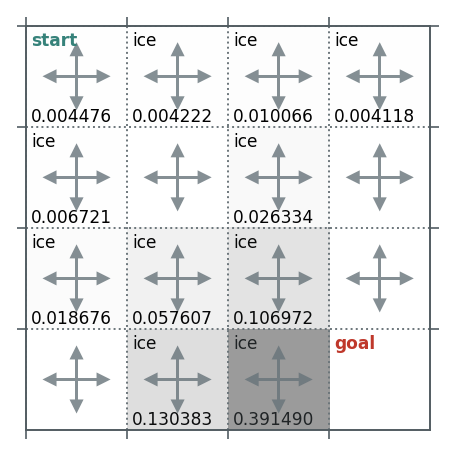

In [11]:
plot(V, policy,1.0,draw_vals=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


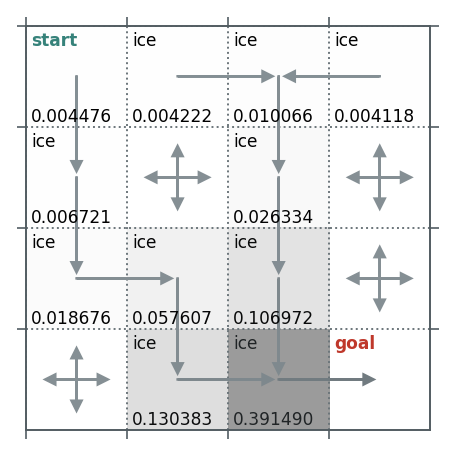

In [12]:
policy = policy_improvement(env, V, gamma=0.9)
plot(V, policy, 1.0, draw_vals=True)

In [13]:
name = 'FrozenLake8x8-v1'
env = gym.make(name, is_slippery=False)
env.seed(42)
env.action_space.seed(42)

policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
V = policy_evaluation(env, policy, gamma=0.9, draw=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

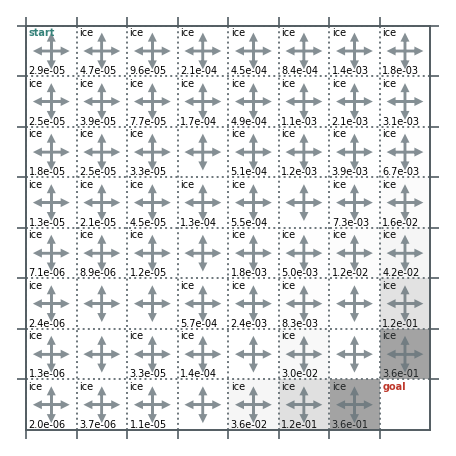

In [14]:
plot(V, policy, 1.0, draw_vals=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


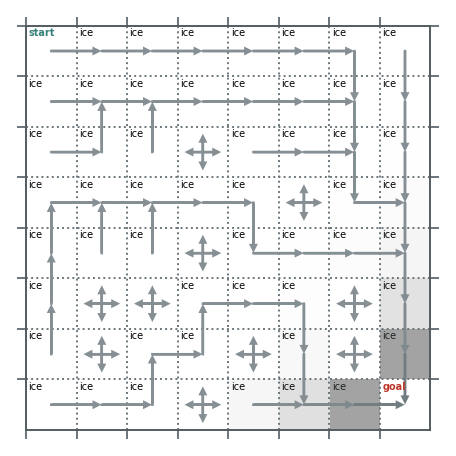

In [15]:
new_policy = policy_improvement(env, V, gamma=0.9)
plot(V, new_policy)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


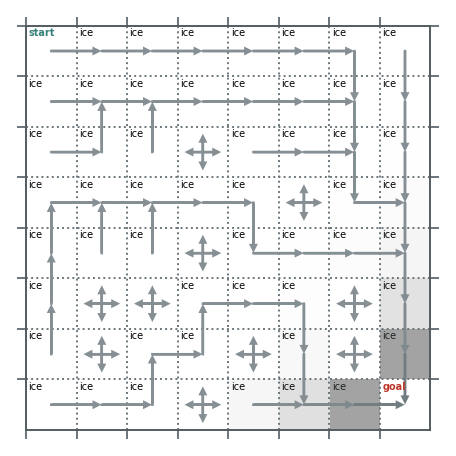

In [16]:
V = policy_evaluation(env, policy, gamma=0.9, draw=False)
new_policy = policy_improvement(env, V, gamma=0.9)
plot(V, new_policy)

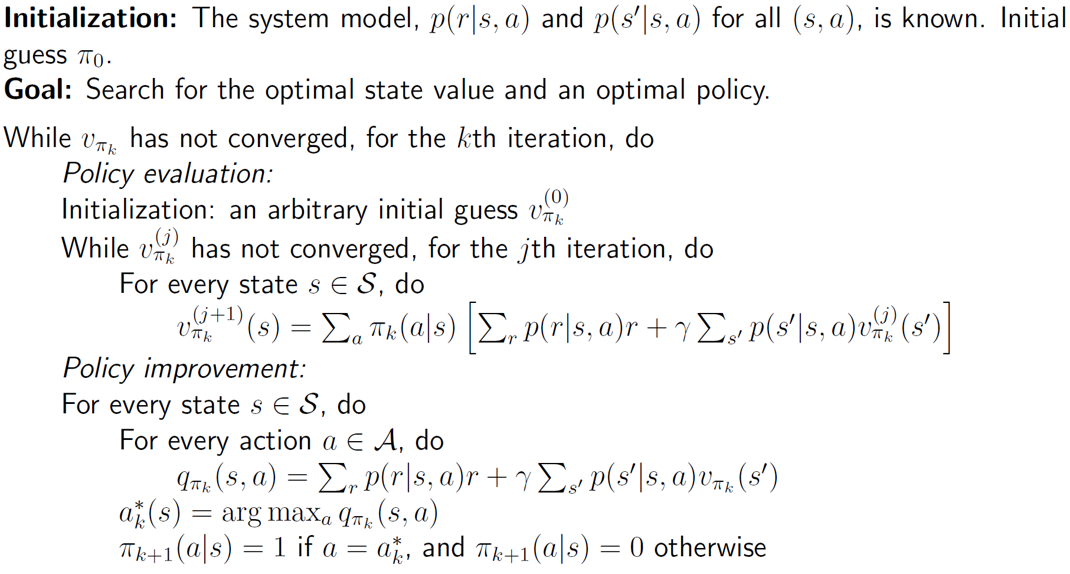

In [17]:
def policy_iteration(env, gamma=1, theta=1e-6):
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
    while True:
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V, gamma)

        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta:
            break

        policy = copy.copy(new_policy)
    return policy, V

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


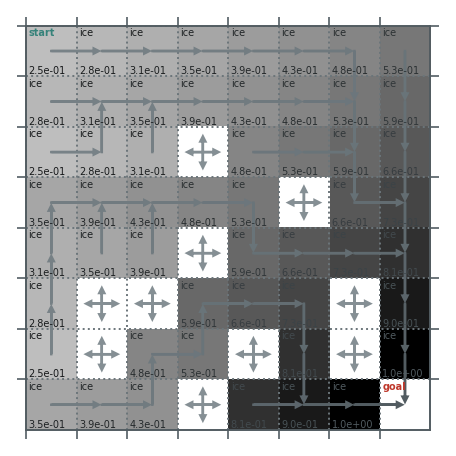

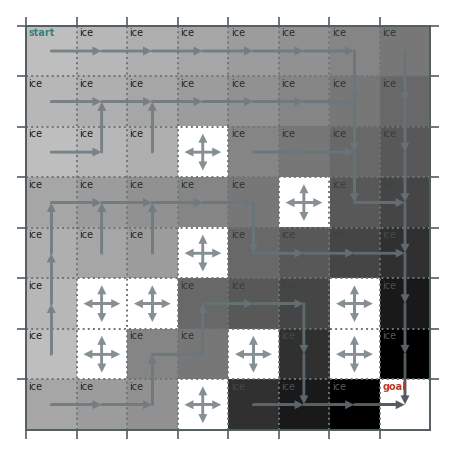

In [18]:
policy_pi, V_pi = policy_iteration(env, gamma=0.9)
plot(V_pi, policy_pi, 1.0, draw_vals=True)
plot(V_pi, policy_pi, 1.0, draw_vals=False)

## Truncated Policy Iteration

## Value Iteration

## Nhận xét kết quả thực nghiệm